### Abstract

We are interested to understand how people adjust their behaviour to the underlying temporal structure of changes. For this purpose we have modified a standard reversal learning task to include exploratory (epistemic) choices, which participants can use to learn the correct choice on the current trial. Participants were separated in two groups, each group exposed to different experimental conditions characterised by a different temporal structure of reversals.

In the first condition participants were exposed to regular (predictable) reversals for 800 trials and then to irregular sequence of reversals for 200 trials (same reversal rate but les predictable moment of reversals). In the second condition, the participant were first exposed to the irregular reversals (for 800 trials) and then to a sequence of regular reversal 200 trials.

Quanitfying probability of exploratory choices at each trial relative to the moment of reversals we can identify distinct characteristic responses of behaviour in two experimental conditions. This results suggest that people are sensitive to the temporal structure of the reversals (they can learn it) and that they use this structure for infering most likely moments of reversals, as reflected in the statistics of exploratory choices.

In [25]:
# load behavioural data
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(context='notebook', style = 'white', color_codes = True)
%matplotlib inline

from stats import trials_until_correct, trials_until_explore, running_mean

import sys
import os

import os
cwd = os.getcwd()

sys.path.append(cwd[:-len('befit/examples/temp_rev_learn')])

df_res = pd.read_csv('pilot/responses.csv').set_index('subject')
responses = df_res.values[:, :-2].T.astype(float)

outcomes = pd.read_csv('pilot/outcomes.csv').set_index('subject').values.T.astype(float)
corrects = pd.read_csv('pilot/correct_responses.csv').set_index('subject').values.T.astype(float)

states_and_rewards = io.loadmat('pilot/states_and_rewards.mat')
Sirr = states_and_rewards['irregular']['S'][0, 0][:, 0] - 1
Oirr = states_and_rewards['irregular']['R'][0, 0]
Sreg = states_and_rewards['regular']['S'][0, 0][:, 0] - 1
Oreg = states_and_rewards['regular']['R'][0, 0]

ns_reg = (df_res['condition'] == 'regular').sum()   # number of subjects in the regular reversals group
ns_irr = (df_res['condition'] == 'irregular').sum()  # number of subjects in the irregular reversals group

nsub = responses.shape[-1]

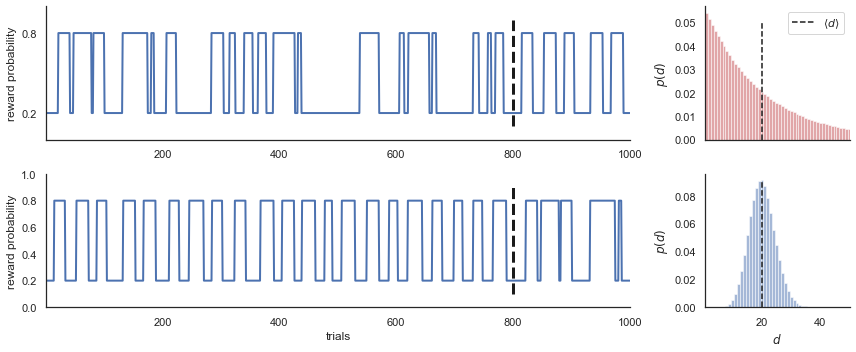

In [97]:
import torch
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(12, 5), sharex=True)
gs = axes[0, 0].get_gridspec()
# remove the underlying axes
for ax in axes[:, :-1].flatten():
    ax.remove()
axbig1 = fig.add_subplot(gs[0, :-1])
axbig2 = fig.add_subplot(gs[1, :-1])

trials = np.arange(1, len(Sirr) + 1)

axbig1.plot(trials, .6 * Sirr + .2, lw=2)

axbig1.vlines(800, .1, .9, lw=3, linestyle='--')
axbig1.set_yticks([.2, .8])
axbig1.set_ylabel('reward probability')

axbig2.plot(trials, .6 * Sreg + .2, lw=2)
axbig2.vlines(800, .1, .9, lw=3, linestyle='--')
axbig2.set_ylabel('reward probability')
axbig2.set_xlabel('trials')

axbig1.set_xlim([1, len(Sirr)])
axbig1.set_ylim([.0, 1.])

axbig2.set_xlim([1, len(Sirr)])
axbig2.set_ylim([.0, 1.])

mu = 19
color = ['r', 'b']
d = torch.arange(1., 51.)
for i, phi in zip(range(3), torch.tensor([1., 10000.])):
    k = d - 1
    lbinom = torch.lgamma(k + phi) - torch.lgamma(d) - torch.lgamma(phi)
    delta = mu / (mu + phi)
    p0 = torch.softmax( lbinom + k * delta.log() + phi * (1-delta).log(), -1)
    axes[i, -1].bar(d.numpy(), p0.numpy(), alpha = .5, color=color[i], width=1)
    axes[i, -1].set_xlim([.5, 50])
    
axes[0, -1].vlines(20, 0, 0.05, linestyle='--', label=r'$\langle d \rangle$')
axes[1, -1].vlines(20, 0, 0.09, linestyle='--')
axes[0, -1].legend()

axes[0, -1].set_ylabel(r'$p(d)$')
axes[1, -1].set_ylabel(r'$p(d)$')
axes[1, -1].set_xlabel(r'$d$')

fig.align_labels()
fig.tight_layout()
sns.despine(fig)
fig.savefig('exp_rev_schedule.svg', transparent=True)

In [136]:
# remove subjects which did not generate exploratory responses
expl_subs = (responses == 2).sum(0) > 20
expl_sub_num = np.arange(nsub)[expl_subs]
nexpl_sub_num = np.arange(nsub)[~expl_subs]

reg_out = outcomes[..., expl_sub_num[expl_sub_num < ns_reg]]
irr_out = outcomes[..., expl_sub_num[expl_sub_num >= ns_reg]]

reg_res = responses[..., expl_sub_num[expl_sub_num < ns_reg]]
irr_res = responses[..., expl_sub_num[expl_sub_num >= ns_reg]]

reg_corr = corrects[..., expl_sub_num[expl_sub_num < ns_reg]]
irr_corr = corrects[..., expl_sub_num[expl_sub_num >= ns_reg]]

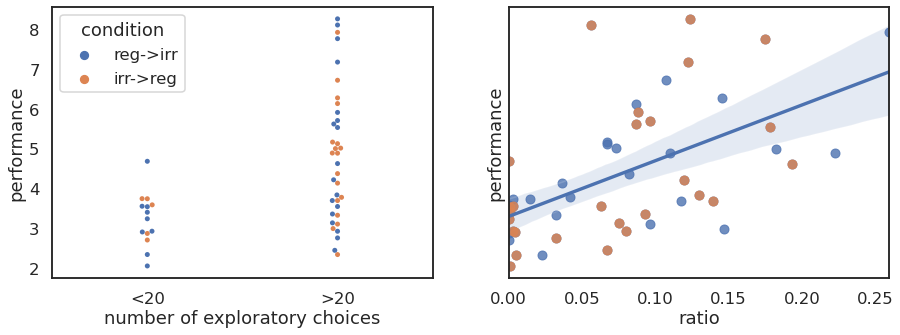

In [138]:
prob = np.nanmean(corrects, -2)
df = pd.DataFrame({'performance': prob/(1 - prob)})

df['exploration'] = np.sum(responses == 2, -2)/1000.
df['ratio'] = df['exploration'] / (1 - df['exploration'])


df['hints'] = '<20'
df.loc[expl_sub_num, 'hints'] = '>20'

df['condition'] = 'reg->irr'
df.loc[ns_reg:, 'condition'] = 'irr->reg'

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
sns.swarmplot(x='hints', y='performance', data=df, hue='condition', ax=axes[0]);
sns.regplot(x='ratio', y='performance', data=df, ax=axes[1]);
sns.regplot(x='ratio', y='performance', data=df.loc[df.condition == 'reg->irr'], ax=axes[1], fit_reg=False);

axes[0].set_xlabel('number of exploratory choices');
#fig.savefig('Fig3.pdf', bbox_inches='tight', transparent=True, dpi=300)

In [4]:
trials = 1000
def get_reversal_statistics(responses, corrects, states, nsub, delta=200):

    A = responses.T == 2
    C = corrects.T

    reversal = np.abs(np.diff(states.flatten())).astype(bool)
    trials = np.arange(1, 1000)[reversal]
    perf = {}
    expl = {}
    for t in trials:
        block = np.long(np.floor(t/delta))
        perf.setdefault(block, [])
        perf[block].append(C[:,t-10:t+10])
        
        expl.setdefault(block, [])
        expl[block].append(A[:,t-10:t+10])
        
    for block in expl:
        perf[block] = np.nanmean(np.stack(perf[block]), 0)
        expl[block] = np.nanmean(np.stack(expl[block]), 0)
    
    return perf, expl

In [5]:
nsub = reg_res.shape[-1]
reg_perf, reg_expl = get_reversal_statistics(reg_res, reg_corr, Sreg, nsub)

nsub = irr_res.shape[-1]
irr_perf, irr_expl = get_reversal_statistics(irr_res, irr_corr, Sirr, nsub)

t = np.arange(-10, 10)

# Simulated data

Prior over durations is set to the negative binomial distribution defined as 

$$p_0(d) = \binom{d + \varphi - 2}{d-1} \left( \frac{\mu}{\mu + \varphi}\right)^{d-1} \left( \frac{\varphi}{\mu + \varphi} \right)^\varphi, \:\: d \in \{1, 2, \ldots \}$$

with

\begin{equation}
\begin{split}
E[d] &= \mu + 1\\
Var[d] &= \mu + \mu^2/\varphi
\end{split}
\end{equation}

mean =  tensor(20.)
mean =  tensor(20.0000)
mean =  tensor(19.9930)


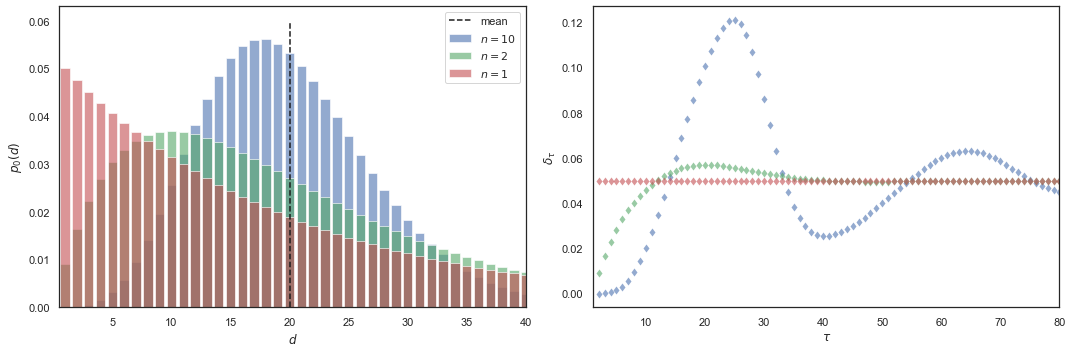

In [100]:
import torch

def evolve_change_prob(S, D, T):
    # joint transition matrix
    tm=torch.einsum('ijk,lk->iljk', S, D)
    
    #change probability
    dlt_tau = torch.zeros(T-1)
    
    #joint_probability if the previous state was non reversal 
    #and the previous state duration follows the prior p0(d)
    joint = torch.einsum('ijkl,l->ijk', tm, D[:,0])[:,:,0]
    
    #estimate change probability delta_tau at a future trial tau
    for tau in range(T-1):
        marg_prob = joint.sum(1)
        if tau == 0:
            dlt_tau[tau] = marg_prob[1]
        else:
            dlt_tau[tau] = marg_prob[1,0]/marg_prob[:,0].sum(0)
            joint = joint.sum(-1)
        
        joint = torch.einsum('ijkl,kl->ijk', tm, joint)
    
    return dlt_tau

d_max = 200 #maximal interval duration
d = torch.arange(1., d_max+1., 1.)

ds = 2
R = (torch.ones(ds,ds) - torch.eye(ds))/(ds-1)
S = torch.zeros(ds,ds,d_max)
S[:,:,0] = R
S[:,:,1:] = torch.eye(ds).reshape(ds, ds, 1)

D = torch.zeros(d_max, d_max)
for k in range(1,d_max):
    D[k-1, k] = 1 

fig, ax = plt.subplots(1, 2, figsize = (15,5), tight_layout=True)

mu = 19
color = ['b', 'g', 'r']
labels = [r'$\sigma = \mu$', r'$\sigma = 10\mu$', r'$\sigma = (\mu-1)\mu$']
for i, phi in zip(range(3), torch.tensor([10., 2., 1.])):
    k = d - 1
    lbinom = torch.lgamma(k + phi) - torch.lgamma(d) - torch.lgamma(phi)
    delta = mu / (mu + phi)
    sig = np.sqrt(mu + mu**2/phi)
    p0 = torch.softmax( lbinom + k * delta.log() + phi * (1-delta).log(), -1)
    print('mean = ', torch.sum(d*p0))
    D[:,0] = p0
    ax[0].bar(np.arange(d_max)+1, p0.numpy(), alpha = 0.6, label = r'$n={}$'.format(int(phi)), color=color[i])
    T = 100
    ax[1].plot(np.arange(2, T+1, 1), evolve_change_prob(S, D, T).numpy(), 'd', alpha=.6, 
               label =labels[i], color=color[i], markeredgecolor='none')

ax[0].vlines(mu+1, 0, .06, 'k', linestyle='--', label='mean')
ax[0].legend()
ax[0].set_xlim([.5,40])
ax[0].set_xlabel('$d$')
ax[0].set_ylabel('$p_0(d)$')

ax[1].set_ylabel(r'$\delta_{\tau}$')
ax[1].set_xlabel(r'$\tau$')
ax[1].set_xlim([1,80])

fig.savefig('distribution.svg', bbox_inches='tight', transparent=True, dpi=300)

Here we will try to reproduce charachteristic response patterns using behavioural models based on an active inference agent equipped with an explicit representation of duration. 

In [7]:
blocks = 1 # number of blocks
nsub = 100  # number of subjects
trials = 1000  # number of samples

from torch import zeros, ones, tensor

from befit.tasks import TempRevLearn
from befit.agents import ExplicitHMM
from befit.simulate import Simulator

reg_rewards = torch.from_numpy(Oreg).reshape(1, trials, 1, 2).repeat(1, 1, nsub, 1)
reg_rewards = ((reg_rewards + 1)//2).long()
irr_rewards = torch.from_numpy(Oirr).reshape(1, trials, 1, 2).repeat(1, 1, nsub, 1)
irr_rewards = ((irr_rewards + 1)//2).long()

reg_states = torch.from_numpy(Sreg).reshape(1, trials, 1).repeat(1, 1, nsub).long()
irr_states = torch.from_numpy(Sirr).reshape(1, trials, 1).repeat(1, 1, nsub).long()

offers = zeros(blocks, trials, nsub, dtype=torch.long)

reg_stimuli = {'states': reg_states, 
               'rewards': torch.cat([reg_rewards, reg_states[..., None] + 2], -1), 
               'offers': offers}

reg_temprev = TempRevLearn(reg_stimuli, nsub=nsub)

irr_stimuli = {'states': irr_states, 
               'rewards': torch.cat([irr_rewards, irr_states[..., None] + 2], -1), 
               'offers': offers}

irr_temprev = TempRevLearn(irr_stimuli, nsub=nsub)

# agents in condition with regular reversals
trans_pars = torch.stack([tensor([[0., 4., 0., -.5, 0., 0., 0.]]) + torch.randn(nsub//2, 7)*torch.tensor([.1, .1, .1, .1, .1, .1, .1]), 
                          tensor([[0., 0., 0., -.5, 0., 0., 0.]]) + torch.randn(nsub//2, 7)*torch.tensor([.1, .1, .1, .1, .1, .1, .1])],
                         dim=0).reshape(-1, 7)

edhmm_agent1 = ExplicitHMM(runs=nsub, trials=trials)
edhmm_agent1.set_parameters(trans_pars)

edhmm_agent2 = ExplicitHMM(runs=nsub, trials=trials)
edhmm_agent2.set_parameters(trans_pars)

sim = Simulator([reg_temprev, irr_temprev], [edhmm_agent1, edhmm_agent2], trials=trials)
sim.simulate_experiment()
sim.format_stimuli_and_responses();

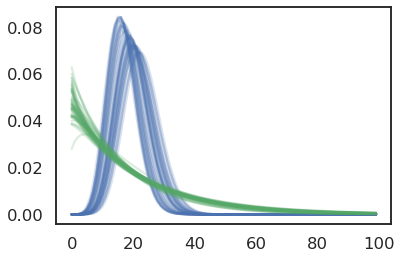

In [8]:
# plot priors over durations
d = torch.arange(1., edhmm_agent1.nd+1.)
plt.plot(edhmm_agent1.pd.numpy()[:nsub//2].T, 'b', alpha=.2);
plt.plot(edhmm_agent1.pd.numpy()[nsub//2:].T, 'g', alpha=.2);

In [9]:
res1 = sim.responses['pair_0']
corrects1 = (reg_states == res1).float()  # correct responses in condition reg->irr
corrects1[res1 == 2] = np.nan
corrects1 = corrects1[0].numpy()

res2 = sim.responses['pair_1']
corrects2 = (irr_states == res2).float()  # correct responses in condition irr->reg
corrects2[res2 == 2] = np.nan
corrects2 = corrects2[0].numpy()

responses1 = res1.float().numpy()[0]
responses2 = res2.float().numpy()[0]

In [10]:
ns = nsub//2

reg_res1 = responses1[..., :ns]
irr_res1 = responses1[..., ns:]
reg_corr1 = corrects1[..., :ns]
irr_corr1 = corrects1[..., ns:]

reg_perf1, reg_expl1 = get_reversal_statistics(reg_res1, reg_corr1, Sreg, ns)
irr_perf1, irr_expl1 = get_reversal_statistics(irr_res1, irr_corr1, Sreg, ns)

reg_res2 = responses2[..., :ns]
irr_res2 = responses2[..., ns:]
reg_corr2 = corrects2[..., :ns]
irr_corr2 = corrects2[..., ns:]
reg_perf2, reg_expl2 = get_reversal_statistics(reg_res2, reg_corr2, Sirr, ns)
irr_perf2, irr_expl2 = get_reversal_statistics(irr_res2, irr_corr2, Sirr, ns)

## Prior predictive check based on rolling performance

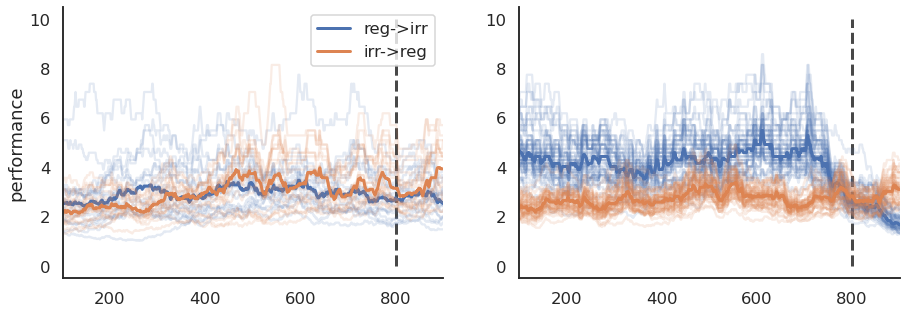

In [43]:
def plot_time_series(values, trials, ax, label):
    g = ax.plot(trials, np.median(values, 0), lw=3, label=label)
    ax.plot(trials, values.T, alpha=.15, color=g[0]._color)
    
def odds(x):
    return x/(1 - x)
    
def performance(correct, ws=100):
    return odds(running_mean(correct.T, ws=ws))

irr_expl_data = irr_res.T == 2
reg_expl_data = reg_res.T == 2
irr_expl_model = irr_res2.T == 2
reg_expl_model = reg_res1.T == 2
    
window_size = 201

rolling_perf_reg = performance(reg_corr, ws=window_size)
rolling_perf_irr = performance(irr_corr, ws=window_size)

rolling_perf_reg_model = performance(reg_corr1, ws=window_size)
rolling_perf_irr_model = performance(irr_corr2, ws=window_size)

trials = np.arange((window_size - 1)//2 + 1, (window_size - 1)//2 + 1 + rolling_perf_reg.shape[-1], 1)

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
plot_time_series(rolling_perf_reg, trials, axes[0], 'reg->irr')
plot_time_series(rolling_perf_irr, trials, axes[0], 'irr->reg')
axes[0].legend()

plot_time_series(rolling_perf_reg_model, trials, axes[1], None)
plot_time_series(rolling_perf_irr_model, trials, axes[1], None)

axes[0].vlines(800, 0, 10, 'k', linestyle='--', lw=3, alpha=.8)
axes[1].vlines(800, 0, 10, 'k', linestyle='--', lw=3, alpha=.8)

axes[0].set_ylabel('performance')

sns.despine(fig)
plt.xlim([trials[0], trials[-1]]);

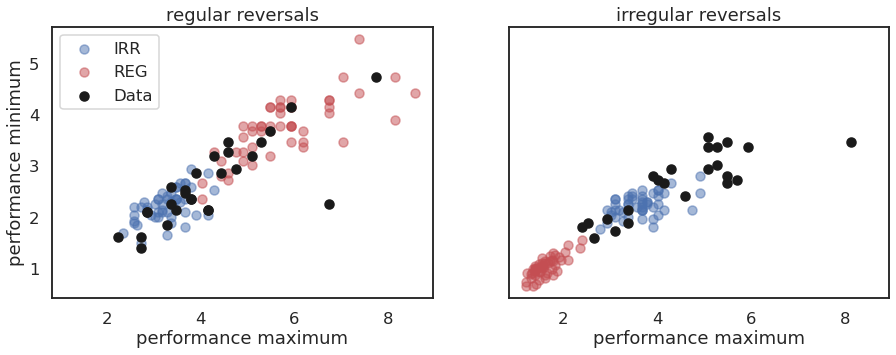

In [68]:
start = 350
end = -200
window_size=201
rolling_perf = performance(corrects, ws=window_size)

rolling_perf1_model = performance(corrects1, ws=window_size)
rolling_perf2_model = performance(corrects2, ws=window_size)

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

axes[0].scatter(rolling_perf1_model[..., start:end].max(-1)[ns:], 
                rolling_perf1_model[..., start:end].min(-1)[ns:], 
                color='b', alpha=.5, label='IRR');
axes[0].scatter(rolling_perf1_model[..., start:end].max(-1)[:ns], 
                rolling_perf1_model[..., start:end].min(-1)[:ns], 
                color='r', alpha=.5, label='REG')
axes[0].scatter(rolling_perf[..., start:end].max(-1)[:ns_reg], 
                rolling_perf[..., start:end].min(-1)[:ns_reg], 
                color='k', label='Data');
axes[0].legend()
axes[0].set_title('regular reversals');
axes[0].set_ylabel('performance minimum');

axes[1].scatter(rolling_perf2_model[..., start:end].max(-1)[ns:], 
                rolling_perf2_model[..., start:end].min(-1)[ns:], 
                color='b', alpha=.5);
axes[1].scatter(rolling_perf2_model[..., start:end].max(-1)[:ns], 
                rolling_perf2_model[..., start:end].min(-1)[:ns], 
                color='r', alpha=.5)
axes[1].scatter(rolling_perf[..., start:end].max(-1)[ns_reg:], 
                rolling_perf[..., start:end].min(-1)[ns_reg:], color='k');
axes[1].set_title('irregular reversals');
axes[0].set_xlabel('performance maximum');
axes[1].set_xlabel('performance maximum');

In [120]:
from sklearn.decomposition import PCA

x1 = np.stack([rolling_perf1_model[..., start:end].max(-1), rolling_perf1_model[..., start:end].min(-1)], -1)
x2 = np.stack([rolling_perf2_model[..., start:end].max(-1), rolling_perf2_model[..., start:end].min(-1)], -1)
x_data = np.stack([rolling_perf[..., start:end].max(-1), rolling_perf[..., start:end].min(-1)], -1) 
pca = PCA(n_components=1).fit(x2)
pc_res1 = pca.transform(x1)
pc_res2 = pca.transform(x2)
pc_res_data = pca.transform(x_data)

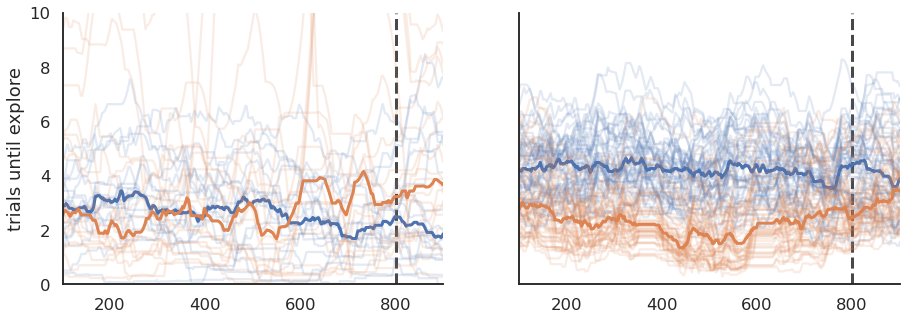

In [32]:
explore = np.concatenate([reg_res == 2, irr_res == 2], -1).T
states = np.concatenate([np.expand_dims(Sreg, -2).repeat(reg_res.shape[-1], 0), 
                         np.expand_dims(Sirr, -2).repeat(irr_res.shape[-1], 0)], 0)
tue_sub = trials_until_explore(explore, states)
rolling_tue_sub = running_mean(tue_sub, ws=201)

# explore = np.concatenate([reg_expl_model, irr_expl_model], 0)
explore = np.concatenate([reg_res1.T == 2, irr_res2.T == 2], 0)
states = np.concatenate([np.expand_dims(Sreg, -2).repeat(50, 0), 
                         np.expand_dims(Sirr, -2).repeat(50, 0)], 0)
tue_model = trials_until_explore(explore, states)
rolling_tue_model = running_mean(tue_model, ws=201)

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True, sharex=True)

plot_time_series(rolling_tue_sub[:reg_res.shape[-1]], trials, axes[0], None)
plot_time_series(rolling_tue_sub[reg_res.shape[-1]:], trials, axes[0], None)
axes[0].set_ylim([0, 10])

plot_time_series(rolling_tue_model[:50], trials, axes[1], None)
plot_time_series(rolling_tue_model[50:], trials, axes[1], None)
axes[1].set_ylim([0, 10])

axes[0].vlines(800, 0, 10, 'k', linestyle='--', lw=3, alpha=.8)
axes[1].vlines(800, 0, 10, 'k', linestyle='--', lw=3, alpha=.8)

axes[0].set_ylabel('trials until explore')

sns.despine(fig)
plt.xlim([trials[0], trials[-1]]);

In [ ]:
start = 350
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].scatter(mean_tuc['irreg'].max(-1)[ns:], mean_tuc['irreg'].min(-1)[ns:], color=color[0], alpha=.5, label='IRR')
axes[0].scatter(mean_tuc['irreg'].max(-1)[:ns], mean_tuc['irreg'].min(-1)[:ns], color=color[1], alpha=.5, label='REG')
axes[0].scatter(mean_tuc_sub[..., start:].max(-1)[ns_reg:], 
                mean_tuc_sub[..., start:].min(-1)[ns_reg:], 
                color='k',
                label='data')
axes[0].legend()
axes[0].set_title('irregular reversals');

axes[1].scatter(mean_tuc['reg'].max(-1)[ns:], mean_tuc['reg'].min(-1)[ns:], color=color[0], alpha=.5)
axes[1].scatter(mean_tuc['reg'].max(-1)[:ns], mean_tuc['reg'].min(-1)[:ns], color=color[1], alpha=.5)
axes[1].scatter(mean_tuc_sub[..., start:].max(-1)[:ns_reg], mean_tuc_sub[..., start:].min(-1)[:ns_reg], color='k')
axes[1].set_title('regular reversals');

## Prior predictive check based on mean performance

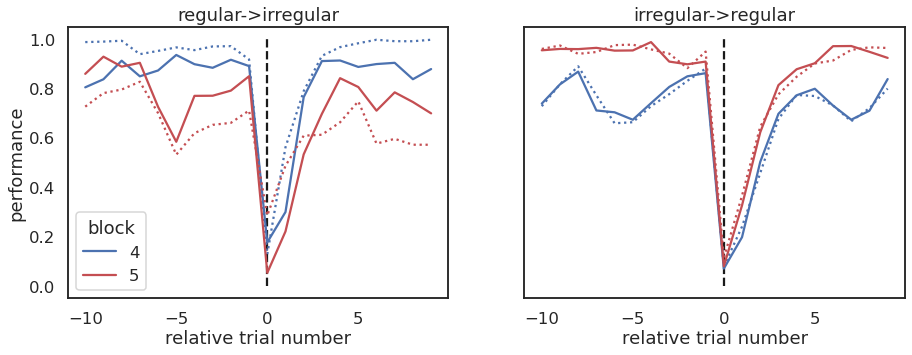

In [14]:
# plot superimposed behavioural and simulated response data
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=True)
color = ['b', 'r']
for block in range(3,5):
    axes[0].plot(t, np.mean(np.vstack(reg_perf[block]), 0), label=block+1, color=color[block-3])
    axes[0].plot(t, np.mean(np.vstack(reg_perf1[block]), 0), ':', color=color[block-3])

    axes[1].plot(t, np.mean(np.vstack(irr_perf[block]), 0), color=color[block-3])
    axes[1].plot(t, np.mean(np.vstack(irr_perf2[block]), 0), ':', color=color[block-3])

axes[0].legend(title='block');
axes[0].vlines(0, 0., 1., 'k', linestyle='--');
axes[1].vlines(0, 0., 1., 'k', linestyle='--');
axes[0].set_xlabel('relative trial number');
axes[1].set_xlabel('relative trial number');
axes[0].set_title('regular->irregular');
axes[1].set_title('irregular->regular');
axes[0].set_ylabel('performance')
fig.savefig('performance_trial.svg', bbox_inches='tight', transparent=True, dpi=300)

## Prior predictive check based on trials until correct

We can calculate how many trials it takes the participants (and agents) to recognize that a reversal has occurred. We define the trials until correct as the number of trials after a reversal that the participant (agent) needed to choose the correct action $\tau$ trials in a row.

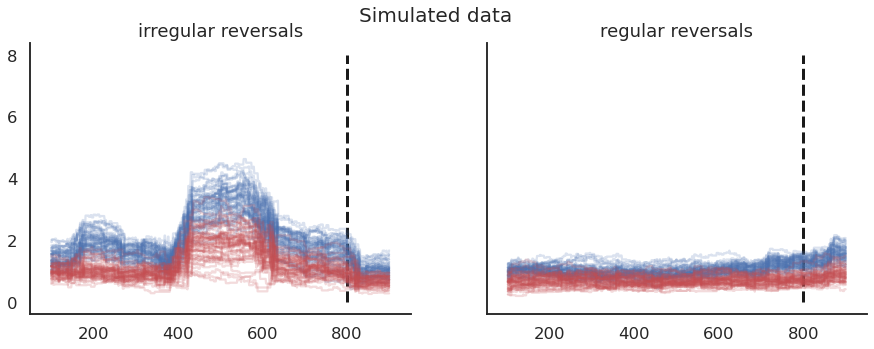

In [15]:
tuc1 = trials_until_correct(np.nan_to_num(corrects1.T), reg_states[0].numpy().T, τ=3)
tuc2 = trials_until_correct(np.nan_to_num(corrects2.T), irr_states[0].numpy().T, τ=3)
tuc = [tuc2, tuc1]

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
color = ['b', 'r']
trials = np.arange(101, 901, 1)

mean_tuc = {}
for i, cond in enumerate(['irreg', 'reg']):
        mean_tuc[cond] = running_mean(tuc[i], ws=201)
        axes[i].plot(trials, mean_tuc[cond][ns:].T, color[0], alpha=.2);
        axes[i].plot(trials, mean_tuc[cond][:ns].T, color[1], alpha=.2);
        axes[i].vlines(800, 0, 8, 'k', linestyle='--', lw=3);
        axes[i].set_title('{}ular reversals'.format(cond))

axes[1].set_title('regular reversals')

axes[0].set_xlim([51, 951])

sns.despine(fig)

fig.suptitle('Simulated data', fontsize=20);

Blue lines show show the rolling mean, windows size 100, of the trials until correct for the group of agents with beliefs about irregular reversals. Similarly, the red lines show the mean trials until correct for the agents with beliefs about regular reversals. Interestingly, in both conditions the agents with beliefs about regular reversals show on average lower mean trials until correct. 

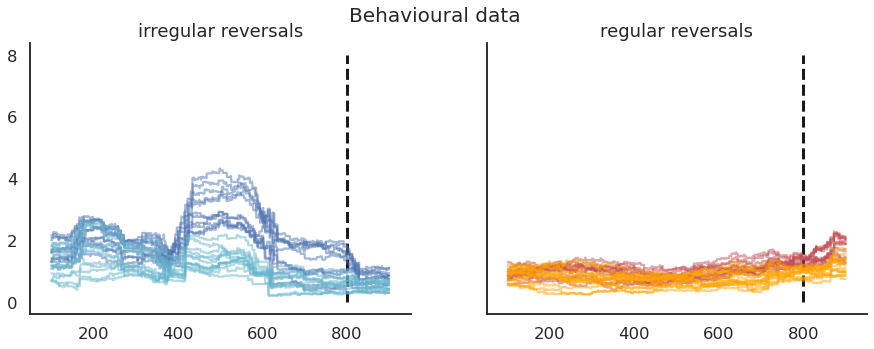

In [16]:
states = np.concatenate([np.expand_dims(Sreg, -2).repeat(ns_reg, 0), 
                         np.expand_dims(Sirr, -2).repeat(ns_irr, 0)], 0)
tuc_sub = trials_until_correct(np.nan_to_num(corrects).T, states, τ=3)
mean_tuc_sub = running_mean(tuc_sub, ws=201)

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

split1 = mean_tuc_sub[ns_reg:, 451] > np.median(mean_tuc_sub[ns_reg:, 451])
axes[0].plot(trials, mean_tuc_sub[ns_reg:][split1].T, 'b', alpha=.5);
axes[0].plot(trials, mean_tuc_sub[ns_reg:][~split1].T, 'c', alpha=.5);
axes[0].vlines(800, 0, 8, 'k', linestyle='--', lw=3);
axes[0].set_title('irregular reversals');

split2 = mean_tuc_sub[:ns_reg, 751] > np.median(mean_tuc_sub[:ns_reg, 751])
axes[1].plot(trials, mean_tuc_sub[:ns_reg][split2].T, 'r', alpha=.5);
axes[1].plot(trials, mean_tuc_sub[:ns_reg][~split2].T, 'orange', alpha=.5);
axes[1].vlines(800, 0, 8, 'k', linestyle='--', lw=3);
axes[1].set_title('regular reversals');

axes[0].set_xlim([51, 951])
sns.despine(fig)

fig.suptitle('Behavioural data', fontsize=20);

The lines show the rolling mean (windows size 100) of the trials until correct for the participants in the two conditions. To illustrate the similarity with simulated data above, we have color coded the participants' trajectories depending on the estimated mean trial until correct. For the condition with irregular reversals, participants above the median value on the 500th trial where color coded blue, and participants bellow the median with cyan. Similarly, for the condition with regular reversals, the participants above the median value on the 800th trial where color coded red, and participants bellow the median with orange.

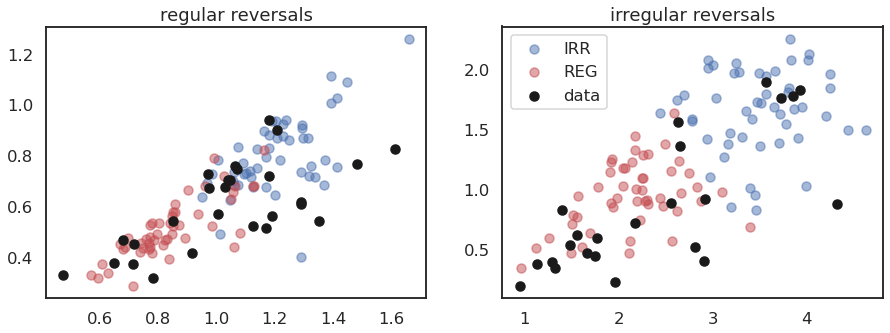

In [122]:
start = 350
end=-200
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[1].scatter(mean_tuc['irreg'][..., start:end].max(-1)[ns:], 
                mean_tuc['irreg'][..., start:end].min(-1)[ns:], 
                color=color[0], alpha=.5, label='IRR')
axes[1].scatter(mean_tuc['irreg'][..., start:end].max(-1)[:ns], 
                mean_tuc['irreg'][..., start:end].min(-1)[:ns], 
                color=color[1], alpha=.5, label='REG')
axes[1].scatter(mean_tuc_sub[..., start:end].max(-1)[ns_reg:], 
                mean_tuc_sub[..., start:end].min(-1)[ns_reg:], 
                color='k',
                label='data')
axes[1].legend()
axes[1].set_title('irregular reversals');

axes[0].scatter(mean_tuc['reg'][..., start:end].max(-1)[ns:], 
                mean_tuc['reg'][..., start:end].min(-1)[ns:], 
                color=color[0], alpha=.5)
axes[0].scatter(mean_tuc['reg'][..., start:end].max(-1)[:ns], 
                mean_tuc['reg'][..., start:end].min(-1)[:ns], 
                color=color[1], alpha=.5)
axes[0].scatter(mean_tuc_sub[..., start:end].max(-1)[:ns_reg], 
                mean_tuc_sub[..., start:end].min(-1)[:ns_reg], color='k')
axes[0].set_title('regular reversals');

In [128]:
x1 = np.stack([mean_tuc['reg'][..., start:end].max(-1), mean_tuc['reg'][..., start:end].min(-1)], -1)
x2 = np.stack([mean_tuc['irreg'][..., start:end].max(-1), mean_tuc['irreg'][..., start:end].min(-1)], -1)
x_data = np.stack([mean_tuc_sub[..., start:end].max(-1), mean_tuc_sub[..., start:end].min(-1)], -1) 
pca = PCA(n_components=1).fit(x2)
pc_res1_tuc = pca.transform(x1)
pc_res2_tuc = pca.transform(x2)
pc_res_data_tuc = pca.transform(x_data)

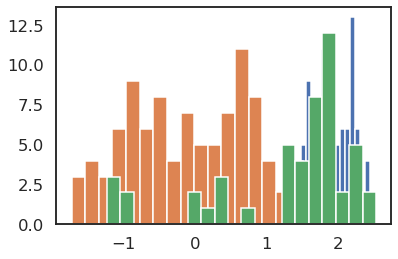

In [124]:
plt.hist(pc_res1_tuc, bins=20);
plt.hist(pc_res2_tuc, bins=20);
plt.hist(pc_res_data_tuc, bins=20);

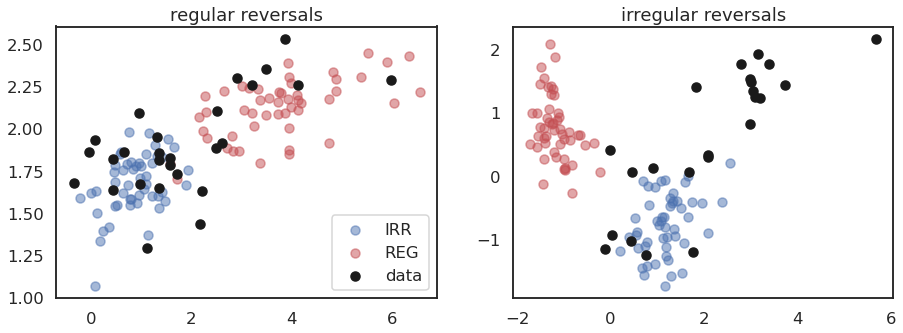

In [134]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].scatter(pc_res1[ns:], 
                pc_res1_tuc[ns:], 
                color=color[0], alpha=.5, label='IRR')
axes[0].scatter(pc_res1[:ns], 
                pc_res1_tuc[:ns], 
                color=color[1], alpha=.5, label='REG')
axes[0].scatter(pc_res_data[:ns_reg], 
                pc_res_data_tuc[:ns_reg], 
                color='k',
                label='data')
axes[0].legend(loc=4)
axes[0].set_title('regular reversals');

axes[1].scatter(pc_res2[ns:], 
                pc_res2_tuc[ns:], 
                color=color[0], alpha=.5)
axes[1].scatter(pc_res2[:ns], 
                pc_res2_tuc[:ns], 
                color=color[1], alpha=.5)
axes[1].scatter(pc_res_data[ns_reg:], 
                pc_res_data_tuc[ns_reg:], color='k')
axes[1].set_title('irregular reversals');